# Align the Book and Movie

In [33]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import re
import pylcs
import json
from collections import Counter
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set the path for the scene break file

In [34]:
SCENE_BREAK_PATH = "processed/shotdetect/scene_detect_output.mat"

# Utilities

In [35]:
def savecache(data, name):
    np.save(f"{name}.npy", data)

def loadcache(name):
    out = np.load(f"{name}.npy", allow_pickle=True)
    if isinstance(out, np.ndarray):
        return out
    else:
        return out.item()

# Load Scene Breaks

In [38]:
scene_breaks = sio.loadmat(SCENE_BREAK_PATH)['scene_breaks']
scene_breaks = scene_breaks - 1 # Convert from matlab indexing to python
scene_breaks = np.array(list(filter(lambda x: x[2], scene_breaks)))
# scene_breaks

# Load Shot Boundaries and TimeStamps

Set the path to vid events computed earlier

In [39]:
VIDEVENTS_PATH = "processed/dune/dune.videvents"
shot_boundaries = pd.read_csv(VIDEVENTS_PATH, sep=' ')

# Convert Scene Break to Time Maps

In [40]:
start_times = []
end_times = []
print(shot_boundaries)

       frame      time CVHCI_VIDEOEVENTS_V1
0        314    13.096                  CUT
1        773    32.241                  CUT
2       1080    45.045                  CUT
3       1458    60.811                  CUT
4       1770    73.824                  CUT
...      ...       ...                  ...
2278  211538  8822.897                  CUT
2279  211730  8830.905                  CUT
2280  211870  8836.745                  CUT
2281  212083  8845.628                  CUT
2282  214070  8928.503                  CUT

[2283 rows x 3 columns]


In [41]:
for scene_break in scene_breaks:
    start_shot, end_shot, nshots = scene_break
    
    start_time, end_time = shot_boundaries.iloc[start_shot]['time'], shot_boundaries.iloc[end_shot-1]['time']
    
    start_times.append(start_time)
    end_times.append(end_time)
    
scene_break_times = np.hstack([scene_breaks, np.array(start_times).reshape(-1, 1), np.array(end_times).reshape(-1, 1)])

# Save to cache: start, end, #scenes, start_time, end_time 
savecache(scene_break_times, "scene_break_times")

# Get All Subtitles Within Range

Set the subtitles and transcript path

In [45]:
SRT_PATH = "./processed/dune/dune_sub.srt"
TRANSCRIPT_JSON_PATH = "./processed/dune/dune_transcript.json"

# ***convert srt to transcript json using convert_srt_to_json.py***
import pysrt
from pysrt.srttime import SubRipTime

ALL_SUBS = []
SUBTITLE = pysrt.open(SRT_PATH)
f = open(TRANSCRIPT_JSON_PATH, "r")
f = json.load(f)
TRANSCRIPT = f['transcript']

#Make a video instance

from scripts.videoDialogueExtractor import Video
video = Video(TRANSCRIPT, scene_break_times)

# Subtitles within range

def get_subtitle_characters(start, end):
    matched_subs = []
    for subtitle in TRANSCRIPT:
        
        if subtitle['type']:
            continue
        
        time = subtitle['time']
        time_s = SubRipTime.from_string(subtitle['time'].split("-->")[0])
        time_ms = time_s.ordinal // 1000

        if time_ms >= start and time_ms <= end:
            if 'actor' in subtitle.keys():
                matched_subs.append(subtitle['actor'])
    return matched_subs
def get_subtitles(start, end):
    
    f = open(TRANSCRIPT_JSON_PATH, "r")
    f = json.load(f)
    TRANSCRIPT = f['transcript']

    matched_subs = []
    for subtitle in TRANSCRIPT:
        
        # if subtitle['type']:
        #     continue

        time = subtitle['time']

        time_s = SubRipTime.from_string(subtitle['time'].split("-->")[0])
        time_ms = time_s.ordinal // 1000
        
#         time_ms = time_s.hour * 60 * 60 + time_s.minute * 60 + time_s.second

        if time_ms >= start and time_ms <= end:
            matched_subs.append(subtitle['line'])
    return matched_subs

# Create Histogram for Movie (NEEDS CHARACTER DIALOGUE, NOT AVAILABLE FOR DUNE)

In [30]:
all_movie_chars = []
OTHER_INDEX = -100

for scene in scene_break_times:
    start, end, num, start_time, end_time = scene
    subs = get_subtitle_characters(start_time, end_time)
    
    for sub_char in subs:
        all_movie_chars.append(sub_char.lower())
    
all_movie_chars = list(set(all_movie_chars))
charIndMapping = {char:i for i, char in enumerate(all_movie_chars)}

KeyError: 'type'

In [ ]:
print("Characters present:\n", charIndMapping)

{'snape': 0,
 'mrs. weasley': 1,
 'flitwick': 2,
 'fred': 3,
 'hermione': 4,
 'the fat lady': 5,
 'neville longbottom': 6,
 'hagrid': 7,
 'petunia': 8,
 'boy': 9,
 'voldemort': 10,
 'harry': 11,
 'seamus': 12,
 'gryffindors': 13,
 'goblin': 14,
 'griphook': 15,
 'sorting hat': 16,
 'oliver': 17,
 'ron and harry': 18,
 'unseen inhuman voice': 19,
 'ron and seamus': 20,
 'girl': 21,
 'filch': 22,
 'tom': 23,
 'dudley': 24,
 'fred and george': 25,
 'hooch': 26,
 'class': 27,
 'ron': 28,
 'neville': 29,
 'percy': 30,
 'vernon': 31,
 'nick': 32,
 'man in a painting': 33,
 'bloody baron': 34,
 'all': 35,
 'crowd': 36,
 'guard': 37,
 'boy 2': 38,
 'snake': 39,
 'george': 40,
 'flint': 41,
 'mcgonagall': 42,
 'lee': 43,
 'firenze': 44,
 'witch': 45,
 'ginny': 46,
 'dean': 47,
 'ollivander': 48,
 'dumbledore': 49,
 'draco': 50,
 'man': 51,
 'all (including flitwick)': 52,
 'quirrell': 53,
 'students': 54,
 'woman': 55}

In [ ]:
OTHER_INDEX = len(all_movie_chars)

# Uncomment this if you want to include unknown characters
# charIndMapping['other'] = OTHER_INDEX
# all_movie_chars.append('other')

Make default histogram

In [ ]:
scene_char_histograms = []

for scene in scene_break_times:
    start, end, num, start_time, end_time = scene
    subs = get_subtitle_characters(start_time, end_time)    
    
    scene_hist = list(np.zeros(len(all_movie_chars)))
    
    for sub_char in subs:
        scene_hist[charIndMapping[sub_char.lower()]] += 1
    
    scene_char_histograms.append(scene_hist)

NameError: name 'all_movie_chars' is not defined

# Get All Book Names

In [ ]:
from scripts.characterNameBookParser import getSpeakerChapterNames, getMentionedChapterNames

Set path to the processed book (from `jsonify_book`) and the book text files

In [ ]:
# BOOK_PROC_PATH = "../book-process/processed_data/Harry_Potter"
# BOOK_TEXT_PATH = "../Soundtracking-Books/data/HP/chapters/"

In [ ]:
# chapter_names = os.listdir(BOOK_PROC_PATH)

Get Character Occurence per chapter

In [ ]:
chapterCharacterCount = list(map(lambda x: getSpeakerChapterNames(os.path.join(BOOK_PROC_PATH, x, x)), chapter_names))

Make character list after taking union

In [ ]:
allBookNames = []

for chapCharCount in chapterCharacterCount:
    for key in chapCharCount.keys():
        allBookNames.append(key.lower())
        
allBookNames = list(set(allBookNames))

Match names in book to subtitle names

In [ ]:
bookMovieNameMap = {}

for name in allBookNames:
    maxLCS = 0
    newname = "NONE"
    
    filtered_name = name.replace("professor", '').replace("aunt", '').replace("uncle", '').strip()
    
    for movie_name in all_movie_chars:        
        lcs = pylcs.lcs2(movie_name, filtered_name)
                
        if lcs > maxLCS:
            
            words = list(filter(lambda x: len(x) > 1 and x.isalpha(), movie_name.split()))
            word_length = list(map(lambda x: len(x), words))

            if len(word_length) == 0:
                continue
            
            if lcs not in word_length and not (lcs > np.max(word_length)):
                continue
            
            maxLCS = lcs
            newname = movie_name
            
    if newname == "NONE":
        print(name, "mapped to other")
        bookMovieNameMap[name] = 'other'
    else:
        print(name, "-", newname)
        bookMovieNameMap[name] = newname      

draco malfoy - draco
snape - snape
grunt - man in a painting
mrs. weasley - mrs. weasley
oliver wood - oliver
fred - fred
hermione - hermione
piers polkiss - man in a painting
hagrid - hagrid
fred weasley - mrs. weasley
petunia - petunia
gryffindor keeper wood - man in a painting
dudley dursley - dudley
nicholas flamel dumbledore - dumbledore
harry - harry
ronan - ron and harry
diagon alley harry - ron and harry
griphook - griphook
mrs. dursley mapped to other
wood mapped to other
the gryffindors - gryffindors
professor quirrell - quirrell
mrs. norris mapped to other
sir nicholas de mimsy mapped to other
filch - filch
dudley - dudley
professor flitwick - flitwick
rubeus hagrid - hagrid
ron - ron and harry
malfoy - man in a painting
neville - neville longbottom
professor dumbledore - dumbledore
percy - percy
madam malkin - man in a painting
gryffindor - man in a painting
hufflepuff mapped to other
diggle mapped to other
friar mapped to other
madam pomfrey - fred and george
halloween mal

Manually fix the incorrect ones - change depending on your book

In [ ]:
bookMovieNameMap['ginny weasley'] = 'ginny'
bookMovieNameMap['slytherins'] = 'other'
bookMovieNameMap['madam malkin'] = 'other'
bookMovieNameMap['professor flitwick'] = 'flitwick'
bookMovieNameMap['madam pomfrey'] = 'other'
bookMovieNameMap['bane'] = 'other'
bookMovieNameMap['jordan'] = 'other'
bookMovieNameMap['grunt'] = 'other'
bookMovieNameMap['norbert the norwegian ridgeback quirrell'] = 'other'
bookMovieNameMap['mrs. dursley'] = 'petunia'
bookMovieNameMap['nicholas flamel dumbledore'] = 'other'
bookMovieNameMap['harry potter'] = 'harry'
bookMovieNameMap['george weasley'] = 'george'
bookMovieNameMap['george'] = 'george'
bookMovieNameMap['seamus finnigan'] = 'seamus'
bookMovieNameMap['finnigan'] = 'other'
bookMovieNameMap['harry '] = 'harry'
bookMovieNameMap['malfoy'] = 'draco'
bookMovieNameMap['gryffindor'] = 'other'
bookMovieNameMap['miss granger'] = 'hermione'
bookMovieNameMap['gryffindor keeper wood'] = 'other'

# Create Book Histogram

In [ ]:
book_chap_histograms = []

for chapCharCount in chapterCharacterCount:

    chap_hist = list(np.zeros(len(all_movie_chars)))

    for key in chapCharCount.keys():
        name = key.lower()
        if bookMovieNameMap[name] != 'other':
            chap_hist[charIndMapping[bookMovieNameMap[name]]] += chapCharCount[key]

    book_chap_histograms.append(chap_hist)

In [ ]:
charIndMapping

{'snape': 0,
 'mrs. weasley': 1,
 'flitwick': 2,
 'fred': 3,
 'hermione': 4,
 'the fat lady': 5,
 'neville longbottom': 6,
 'hagrid': 7,
 'petunia': 8,
 'boy': 9,
 'voldemort': 10,
 'harry': 11,
 'seamus': 12,
 'gryffindors': 13,
 'goblin': 14,
 'griphook': 15,
 'sorting hat': 16,
 'oliver': 17,
 'ron and harry': 18,
 'unseen inhuman voice': 19,
 'ron and seamus': 20,
 'girl': 21,
 'filch': 22,
 'tom': 23,
 'dudley': 24,
 'fred and george': 25,
 'hooch': 26,
 'class': 27,
 'ron': 28,
 'neville': 29,
 'percy': 30,
 'vernon': 31,
 'nick': 32,
 'man in a painting': 33,
 'bloody baron': 34,
 'all': 35,
 'crowd': 36,
 'guard': 37,
 'boy 2': 38,
 'snake': 39,
 'george': 40,
 'flint': 41,
 'mcgonagall': 42,
 'lee': 43,
 'firenze': 44,
 'witch': 45,
 'ginny': 46,
 'dean': 47,
 'ollivander': 48,
 'dumbledore': 49,
 'draco': 50,
 'man': 51,
 'all (including flitwick)': 52,
 'quirrell': 53,
 'students': 54,
 'woman': 55}

Use inverse frequency

In [ ]:
book_chap_all = np.sum(book_chap_histograms, 0)
# book_chap_all

array([ 51.,  27.,   7.,   8., 171.,   7.,  34., 301.,  29.,   0.,   3.,
       469.,   4.,   1.,   0.,   4.,   0.,  23., 431.,   0.,   0.,   0.,
        23.,   0.,  29.,   0.,  15.,   0.,   0.,   0.,   3.,  74.,   1.,
         5.,   0.,   5.,   0.,   0.,   0.,   0.,  12.,   0.,  58.,   0.,
        13.,   0.,   4.,   5.,  21.,  99.,  30.,   0.,   1.,  54.,   0.,
         0.])

In [ ]:
itf_character = 1/np.log(book_chap_all)
itf_character[itf_character == np.inf] = 0

/home/jd/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/jd/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [ ]:
itf_character

array([ 0.25433478,  0.30341308,  0.51389834,  0.48089835,  0.19448958,
        0.51389834,  0.28357849,  0.17522002,  0.2969742 , -0.        ,
        0.91023923,  0.16258569,  0.72134752,  0.        , -0.        ,
        0.72134752, -0.        ,  0.31892899,  0.16485034, -0.        ,
       -0.        , -0.        ,  0.31892899, -0.        ,  0.2969742 ,
       -0.        ,  0.36926937, -0.        , -0.        , -0.        ,
        0.91023923,  0.23233849,  0.        ,  0.62133493, -0.        ,
        0.62133493, -0.        , -0.        , -0.        , -0.        ,
        0.4024296 , -0.        ,  0.24627855, -0.        ,  0.38987125,
       -0.        ,  0.72134752,  0.62133493,  0.32845874,  0.21762218,
        0.2940141 , -0.        ,  0.        ,  0.2506904 , -0.        ,
       -0.        ])

# Compute Similarity Matrix

In [ ]:
import matplotlib.pyplot as plt
from scipy import spatial

In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
# np.array(book_chap_histograms[0])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  5.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., 24.,  0.,  0.,  0.,  0.,  0.,  0., 31.,  0.,  0.,
        0.,  0.,  0.,  0.])

In [ ]:
# book_chap_histograms[0] * itf_character

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.87610012,  1.48487102, -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        ,  5.9106851 , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  6.74628759,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ])

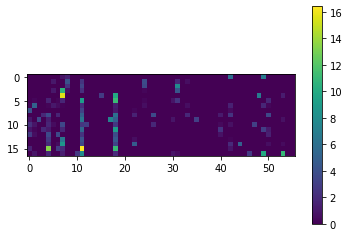

In [ ]:
plt.imshow(book_chap_histograms * itf_character)
plt.colorbar()

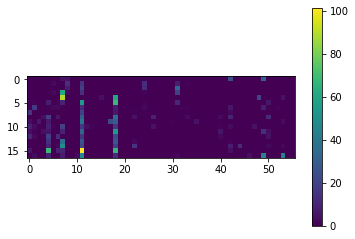

In [ ]:
plt.imshow(book_chap_histograms)
plt.colorbar()

In [ ]:
CHAP_COUNT = len(book_chap_histograms)
SCENE_COUNT = len(scene_char_histograms)

characterSimMat = np.zeros((CHAP_COUNT, SCENE_COUNT))

norm_book_chap_histograms = normalize(book_chap_histograms, axis=1, norm='l2')
norm_scene_char_histograms = normalize(scene_char_histograms, axis=1, norm='l2')

for i in range(CHAP_COUNT):
    for j in range(SCENE_COUNT):
        
        characterSimMat[i][j] = (2 ** 0.5) - np.linalg.norm(norm_scene_char_histograms[j] - norm_book_chap_histograms[i])
#         characterSimMat[i][j] = 1 - spatial.distance.cosine(norm_book_chap_histograms[i], norm_scene_char_histograms[j])
    
        if np.isnan(characterSimMat[i][j]):
            characterSimMat[i][j] = 0

NameError: name 'book_chap_histograms' is not defined

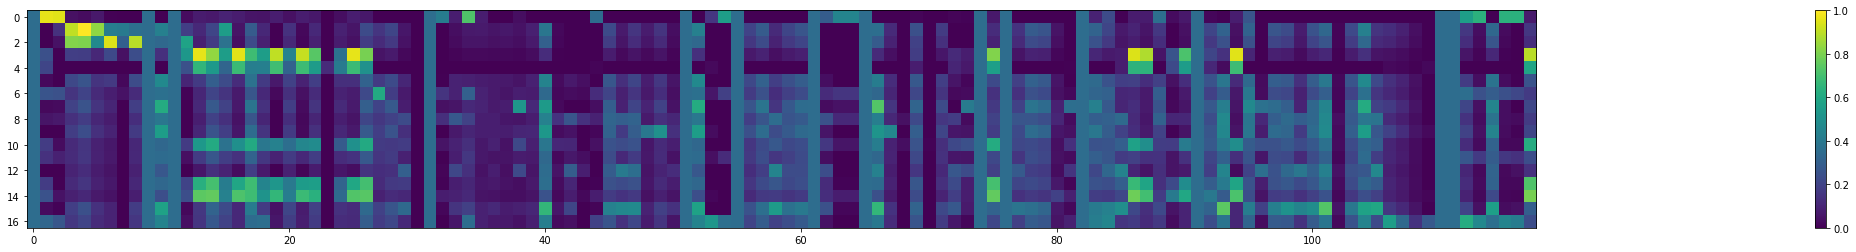

In [ ]:
plt.imshow(characterSimMat/np.max(characterSimMat.flatten()))
plt.colorbar()
plt.gcf().set_figwidth(100)
plt.show()

In [ ]:
normCharacterSimMat = characterSimMat/np.max(characterSimMat.flatten())

In [ ]:
savecache(characterSimMat, 'characterSimMat_120_axis0')

0

In [ ]:
characterSimMat = loadcache('characterSimMat_120_axis0')

# Next Part: Dialogue Matching 

In [46]:
BOOK_PROC_PATH = "./processed/dune/chapters"
BOOK_TEXT_PATH = "./data/dune/book/"

chapter_names = os.listdir(BOOK_PROC_PATH)
from nltk.tokenize import word_tokenize
from scripts.bookQuoteExtractor import Book, getChapterQuotes
chapters = sorted(os.listdir(BOOK_TEXT_PATH), key=lambda x: int(x.split('-')[0]))

# Create book class
book = Book(chapters, BOOK_TEXT_PATH)
chapterText = book.chapterContent
chapterText = list(map(lambda x: x.getText(), chapterText))

# Get all subtitles / dialogues in movie
sceneText = []

for scene in scene_break_times:
    start, end, num, start_time, end_time = scene
    subs = get_subtitles(start_time, end_time)
    
    sceneText.append(subs)

from scripts.lcs import lcs
from scripts.utils import *

Compute Term Frequency for all words in video

In [47]:
f = open(TRANSCRIPT_JSON_PATH, "r")
subtitles = json.load(f)
subtitles = subtitles['transcript']

videoTextAll = ' '.join(list(map(lambda x: x['line'], subtitles))).lower()
videoTextWords = list(map(lambda x: remove_punctuation(remove_extra_whitespace(x)), videoTextAll.split()))
videoWordCount = dict(Counter(videoTextWords))

Compute term frequency for all words in book

In [49]:
bookText = book.getAllText().lower()
bookWords = list(map(lambda x: remove_punctuation(remove_extra_whitespace(x)), bookText.split()))
bookWordCount = dict(Counter(bookWords))

Go Through every chapter, get all dialogues in the chapter, and compute the score

In [50]:
chapterQuotes = list(map(lambda x: getChapterQuotes(os.path.join(BOOK_TEXT_PATH, x + ".txt")), chapter_names))
videoDialogues = list(map(lambda x: video.get_subtitles_in_scene(x), np.arange(len(video))))

def text_process_dialogue(sent):
    sent = lower_text(sent)
    sent = remove_extra_whitespace(sent)
    sent = remove_punctuation(sent)
    sent = word_tokenize(sent)
    
    return sent
    
def text_process_dialogues(sents):
    return list(map(text_process_dialogue, sents))

In [51]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/aneesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [52]:
chapterQuotes = list(map(lambda x: text_process_dialogues(x), chapterQuotes))
videoDialogues = list(map(lambda x: text_process_dialogues(x), videoDialogues))

In [53]:
from multiprocessing import Pool

In [50]:
pool = Pool(10)

In [54]:
CHAP_COUNT = len(chapter_names)
SCENE_COUNT = len(scene_break_times)

dialogueSimMat = np.zeros((CHAP_COUNT, SCENE_COUNT))

Get stopwords

In [55]:
import nltk
from nltk.corpus import stopwords

STOPWORDS = stopwords.words('english')

In [56]:
def simMake(i, j):        
    itf = 0
    scores = []
    dialogues = []
    
    for ii in range(len(chapterQuotes[i])):
        for jj in range(len(videoDialogues[j])):

            matched = lcs(chapterQuotes[i][ii], videoDialogues[j][jj])
            matched = list(filter(lambda x: x not in STOPWORDS, matched))
            
            localItf = 0
            
            for word in matched:
                if word in videoWordCount.keys():
                    localItf += np.log(1/videoWordCount[word])
                else:
                    print(word, "missing")
                    
            scores.append(localItf * len(matched))
            dialogues.append(matched)
            
            itf += localItf * len(matched)
    
    dialogueSimMat[i, j] = itf
    
    # print(i, "Chapter", j, "Scene", "Done:", -itf)    
    # print("--------")
    
    return itf

In [57]:
iterables = []

for i in range(CHAP_COUNT):
    for j in range(SCENE_COUNT):
        iterables.append((i, j))

In [58]:
# result = pool.starmap(simMake, iterables)

from tqdm import tqdm

results = []
for item in tqdm(iterables):
    result = simMake(*item)
    results.append(result)

    

In [59]:
print(results)

NameError: name 'results' is not defined

In [134]:
for idx, iterable in enumerate(iterables):
    i, j = iterable
    dialogueSimMat[i][j] = results[idx]

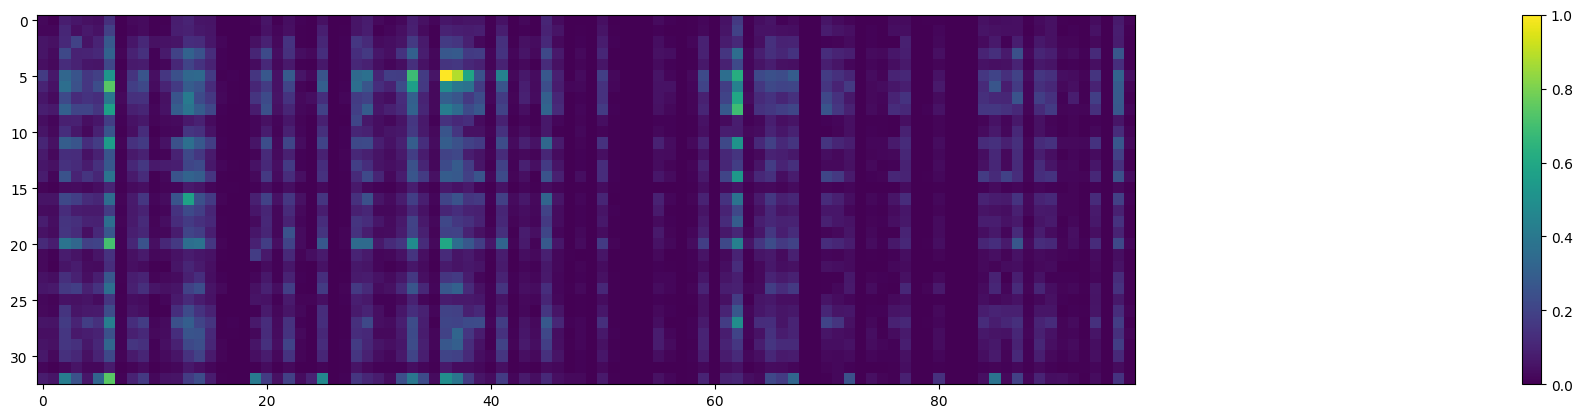

In [139]:
import matplotlib.pyplot as plt

# plt.imshow(-dialogueSimMatLoad/np.max(-dialogueSimMatLoad))
# plt.colorbar()
# plt.gcf().set_figwidth(100)
# plt.show()

plt.imshow(-dialogueSimMat/np.max(-dialogueSimMat))
plt.colorbar()
plt.gcf().set_figwidth(100)
plt.show()

Normed Similarity Matrix for Dialogue

In [143]:
normedDialogueSimMat = -dialogueSimMat/np.max(-dialogueSimMat)
savecache(dialogueSimMat, './notebook_output/dialogueMatch')
savecache(normedDialogueSimMat, './notebook_output/normedDialogueSimMat')

In [60]:
dialogueSimMatLoad = loadcache('./notebook_output/dialogueMatch')
normedDialogueSimMat = loadcache('./notebook_output/normedDialogueSimMat')

# Create Graph

In [62]:
import igraph

G = igraph.Graph(directed=True)

NC = CHAP_COUNT
NS = SCENE_COUNT
S_vertex = NC * NS
T_vertex = NC * NS + 1

"""
Since igraph only supports integer indexing, we convert pixel coordinates to integer.
"""

def tuple_to_int(i, j, col):
    return i * col + j

"""
This converts hashed nodes back to the pixel coordinates.
"""

def int_to_tuple(pt, col):
    y = pt % col
    x = (pt - y)/col
    return (x, y)    

## Make Vertices

In [64]:
vertices = [S_vertex, T_vertex]
_ = [[vertices.append(tuple_to_int(i, j, NS)) for j in range(NS)] for i in range(NC)]
min(vertices), max(vertices)

# Make Edges
edges = []
capacity = []
alpha = 1
gs = []

# Add edges from source

for i in range(NC):
    gaussian_factor = 2 - np.exp(-(i) ** 2/(2*NS**2)) # Equation 7 (Global)
    
    # print(gaussian_factor, S_vertex, tuple_to_int(i, 0, NS))
    
    edges.append([S_vertex, tuple_to_int(i, 0, NS)])
    capacity.append(gaussian_factor)

# Add edges to sink

for i in range(NC):
    gaussian_factor = 2 - np.exp(-(NC-i-1) ** 2/(2*NS**2)) # Equation 7 (Global)  
    
#     print(gaussian_factor, tuple_to_int(i, NS-1, NS), T_vertex)
    
    if i == NC-1:
        gaussian_factor = 0
    
    edges.append([tuple_to_int(i, NS-1, NS), T_vertex])
    capacity.append(gaussian_factor)

In [65]:
np.min(capacity), np.max(capacity)

(0.0, 1.0519150019598995)

Add edge from scene s to scene s+1 for all chapters - local distance - Includes global likelihood

Also subtract the similarity values based on character histograms and 

**This is not done for the first row - no chapter**

In [66]:
edgeWeightMat = np.zeros_like(normedDialogueSimMat)

In [67]:
for j in range(NS-1): # Cannot do the last column / scene
    for i in range(NC):  # For every chapter
        for k in range(NC): # For every next chapter             
            
            if k < i or k > i+1: # FORCE all chapters to only jump to next, not further
                continue
            
            weight = alpha + ((k-i)**2/(2 * NC**2)) # Equation 6 (Local)
            gaussian_factor = 2 - np.exp(-(j - i*(NS/NC)) ** 2/(2*NS**2)) # Equation 7 (Global)
                        
            weight *= gaussian_factor
            gs.append(gaussian_factor)
                        
            # weight -= 0.5 * normCharacterSimMat[k, j+1]
            weight -= normedDialogueSimMat[k, j+1]      # adjusted becuase no character data

#             print(weight, i, j, "->", k, j+1)
                        
            if weight < 0:
                print(weight)
                weight = 0

#             weight *= gaussian_factor
                        
            edgeWeightMat[k, j+1] = weight
            edges.append([tuple_to_int(i, j, NS), tuple_to_int(k, j+1, NS)])
            capacity.append(weight)

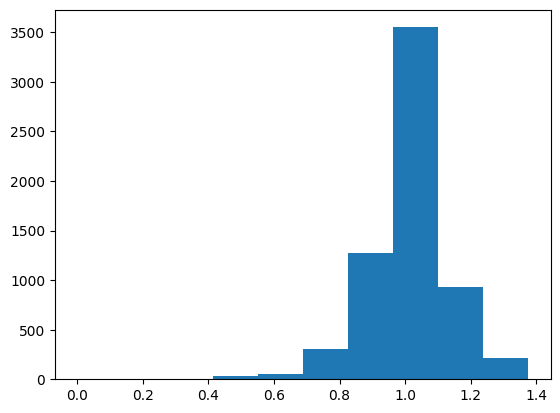

In [69]:
import matplotlib.pyplot as plt
plt.hist(capacity)
plt.show()

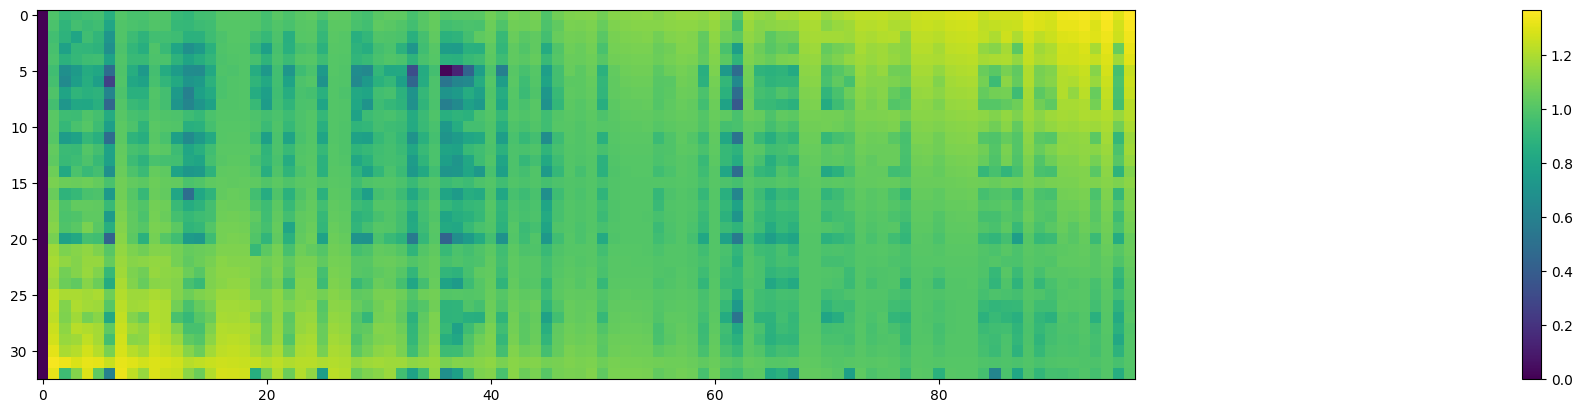

In [70]:
plt.imshow(edgeWeightMat)
plt.colorbar()
plt.gcf().set_figwidth(100)
plt.show()

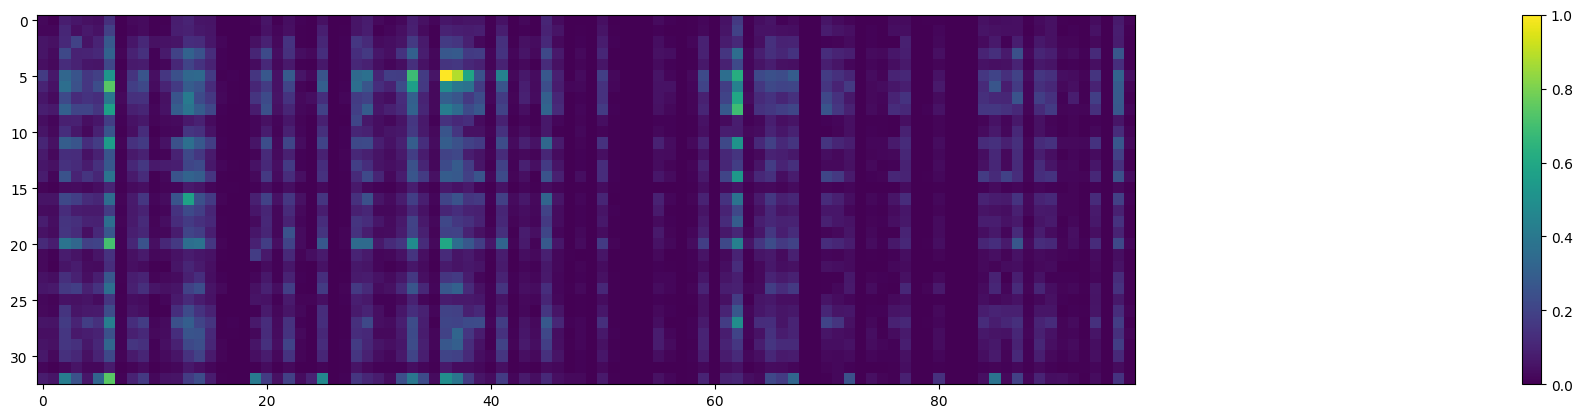

In [71]:
# plt.imshow(0.5 * normCharacterSimMat + 0.5 * normedDialogueSimMat)
plt.imshow(normedDialogueSimMat)
plt.colorbar()
plt.gcf().set_figwidth(100)
plt.show()

In [72]:
mu_g = np.mean(gs)

# Add Things to the Graph

In [73]:
G.add_vertices(vertices)
G.add_edges(edges, {'capacity': capacity})

# Compute Shortest Path

In [188]:
import matplotlib

# matplotlib.use("Qt5Agg")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
#     'font.size': 15,
# })

# matplotlib.rc_file_defaults()

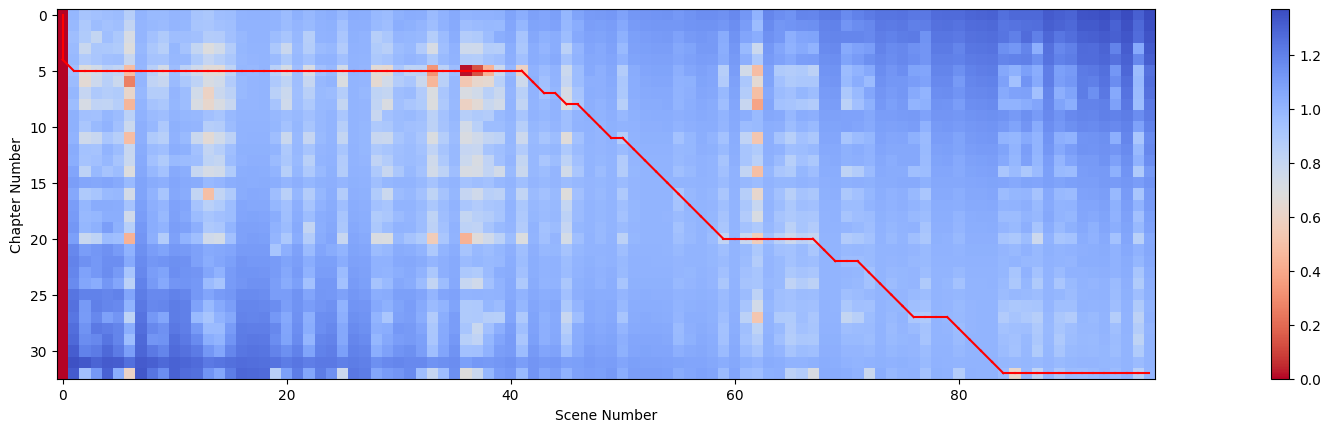

In [74]:
path = G.get_shortest_paths(S_vertex, to=T_vertex, weights=capacity, mode="out", output='vpath')[0][1:-1]
alignment = []

plt.imshow(edgeWeightMat, cmap='coolwarm_r')
prevI = 0
prevJ = 0

for node in path:
    chap, scene = int_to_tuple(node, NS)
    
    alignment.append({
        'chapter': chap,
        'scene': scene
    })
    
    plt.plot([prevJ, scene], [prevI, chap], color="red")
    
    prevI = chap
    prevJ = scene
    
    
plt.colorbar()
plt.gca().set_ylabel("Chapter Number")
plt.gca().set_xlabel("Scene Number")
plt.gcf().set_figwidth(30)
# plt.savefig("graph_b2m.pdf", bbox_inches="tight")
plt.show()

Save to cache

In [75]:
savecache(alignment, './notebook_output/alignment')